# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 13, 34, 20, 537986)

### <span style='color:#ff5f27'> 🚨 Select running mode

In [4]:
#Select whether part E, C or A is run

running_e = False
running_c = False
running_a = True 

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [5]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

if running_e or running_c:
    location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
    location = json.loads(location_str)
    country=location['country']
    city=location['city']
    street=location['street']

if running_a:
    locations_str = secrets.get_secret("SENSOR_LOCATIONS_JSON").value
    locations = json.loads(locations_str)
    country=locations[0]['country']
    city=locations[0]['city']

2025-11-18 13:34:24,911 INFO: Initializing external client
2025-11-18 13:34:24,914 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 13:34:25,695 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 13:34:26,638 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272015


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()

#Model 5 for lagged features!

if running_c:
    retrieved_model = mr.get_model(
        name="air_quality_xgboost_model", 
        version=5, #<-- byt här
    )

if running_a:
    retrieved_model = mr.get_model(
        name="air_quality_xgboost_model", 
        version=6, #<-- byt här
    )

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 13:34:34,457 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/514899 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/551434 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/534022 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/512167 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/498285 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/502074 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120025 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120343 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117623 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118497 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115008 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115107 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25972 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26161 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26629 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25964 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25944 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26666 elapsed<00:00 remaining<?

In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")

if running_e or running_c:
    retrieved_xgboost_model = XGBRegressor()

    retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

    # Displaying the retrieved XGBoost regressor model
    retrieved_xgboost_model

if running_a:
    models = {}
    i=0
    for location in locations:
        retrieved_xgboost_model = XGBRegressor()
        retrieved_xgboost_model.load_model(saved_model_dir + "/model" + str(locations[i]['street']) + ".json")
        models[location['street']] = retrieved_xgboost_model



## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
#Select version of feature group
if running_e:
    w_version = 1

if running_c:
    w_version = 1

if running_a:
    w_version = 2

weather_fg = fs.get_feature_group(
    name='weather',
    version=w_version,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-19 00:00:00+00:00,2.40,0.0,15.683774,301.865936,edinburgh
1,2025-11-20 00:00:00+00:00,3.45,0.0,16.489416,323.880554,edinburgh
2,2025-11-21 00:00:00+00:00,2.80,0.0,12.031756,218.927551,edinburgh
3,2025-11-22 00:00:00+00:00,7.20,0.0,17.727943,209.167511,edinburgh
4,2025-11-23 00:00:00+00:00,3.45,0.1,4.510787,151.389633,edinburgh
5,2025-11-24 00:00:00+00:00,5.95,0.1,24.031178,8.615564,edinburgh


## <span style="color:#ff5f27;">✨ Del C - Populate lagging features   </span>


In [9]:
#Select version of feature group
if running_e:
    aq_version = 1

if running_c:
    aq_version = 2

if running_a:
    aq_version = 3

air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=aq_version,
)
batch_data.sort_values("date")
batch_data.rename(columns={'temperature_2m_mean' : 'weather_temperature_2m_mean', 'precipitation_sum' : 'weather_precipitation_sum','wind_speed_10m_max' : 'weather_wind_speed_10m_max', 'wind_direction_10m_dominant' : 'weather_wind_direction_10m_dominant'}, inplace=True)

if running_c:

    aq_df = air_quality_fg.read().sort_values("date")[-3:]
    aq_df

    for i in range (batch_data.shape[0]):
        if i == 0:
            lagged1_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=1))]
            lagged2_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
            lagged3_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
            
            if not lagged1_df.empty:
                batch_data.loc[i, "lagged_aq_1_day"] = lagged1_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_1_day"] = 'NaN'
            if not lagged2_df.empty:
                batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
            if not lagged3_df.empty:
                batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

        elif i==1:
            batch_data.loc[i, "lagged_aq_1_day"] = batch_data.iloc[i-1]['predicted_pm25']
            
            lagged2_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
            lagged3_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
            
            if not lagged2_df.empty:
                batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
            if not lagged3_df.empty:
                batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

        elif i==2:
            batch_data.loc[i, "lagged_aq_1_day"] = batch_data.iloc[i-1]['predicted_pm25']
            batch_data.loc[i, "lagged_aq_2_days"] = batch_data.iloc[i-2]['predicted_pm25']
            
            lagged3_df = aq_df[aq_df["date"] == (batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
            
            if not lagged3_df.empty:
                batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
            else:
                batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'
            
        else:
            batch_data.loc[i, "lagged_aq_1_day"] = batch_data.iloc[i-1]['predicted_pm25']
            batch_data.loc[i, "lagged_aq_2_days"] = batch_data.iloc[i-2]['predicted_pm25']
            batch_data.loc[i, "lagged_aq_3_days"] = batch_data.iloc[i-3]['predicted_pm25']

        batch_data.loc[i,'predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])[i]

if running_a:
    batch_data_frames = []
    for location in locations:
        street = location['street']

        aq_df = air_quality_fg.filter(air_quality_fg.street == street)
        aq_df = air_quality_fg.read()
        aq_df = aq_df[aq_df['street'] == street]
        aq_df = aq_df.sort_values("date")[-3:]

        temp_batch_data = batch_data.copy()

        for i in range (batch_data.shape[0]):
            if i == 0:
                lagged1_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=1))]
                lagged2_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
                lagged3_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
                
                if not lagged1_df.empty:
                    temp_batch_data.loc[i, "lagged_aq_1_day"] = lagged1_df["pm25"].values[0]
                else:
                    temp_batch_data.loc[i, "lagged_aq_1_day"] = 'NaN'
                if not lagged2_df.empty:
                    temp_batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
                else:
                    temp_batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
                if not lagged3_df.empty:
                    temp_batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
                else:
                    temp_batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

            elif i==1:
                temp_batch_data.loc[i, "lagged_aq_1_day"] = temp_batch_data.iloc[i-1]['predicted_pm25']
                
                lagged2_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=2))]
                lagged3_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
                
                if not lagged2_df.empty:
                    temp_batch_data.loc[i, "lagged_aq_2_days"] = lagged2_df["pm25"].values[0]
                else:
                    temp_batch_data.loc[i, "lagged_aq_2_days"] = 'NaN'
                if not lagged3_df.empty:
                    temp_batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
                else:
                    temp_batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'

            elif i==2:
                temp_batch_data.loc[i, "lagged_aq_1_day"] = temp_batch_data.iloc[i-1]['predicted_pm25']
                temp_batch_data.loc[i, "lagged_aq_2_days"] = temp_batch_data.iloc[i-2]['predicted_pm25']
                
                lagged3_df = aq_df[aq_df["date"] == (temp_batch_data.iloc[i]["date"]-datetime.timedelta(days=3))]
                
                if not lagged3_df.empty:
                    temp_batch_data.loc[i,"lagged_aq_3_days"] = lagged3_df["pm25"].values[0]
                else:
                    temp_batch_data.loc[i, "lagged_aq_3_days"] = 'NaN'
                
            else:
                temp_batch_data.loc[i, "lagged_aq_1_day"] = temp_batch_data.iloc[i-1]['predicted_pm25']
                temp_batch_data.loc[i, "lagged_aq_2_days"] = temp_batch_data.iloc[i-2]['predicted_pm25']
                temp_batch_data.loc[i, "lagged_aq_3_days"] = temp_batch_data.iloc[i-3]['predicted_pm25']

            temp_batch_data['lagged_aq_1_day'] = temp_batch_data['lagged_aq_1_day'].astype(float)
            temp_batch_data['lagged_aq_2_days'] = temp_batch_data['lagged_aq_2_days'].astype(float)
            temp_batch_data['lagged_aq_3_days'] = temp_batch_data['lagged_aq_3_days'].astype(float)
            temp_batch_data.loc[i,'predicted_pm25'] = models[street].predict(
            temp_batch_data[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','weather_temperature_2m_mean', 'weather_precipitation_sum', 'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant']])[i]
        print(temp_batch_data)
        batch_data_frames.append(temp_batch_data)
        
batch_data_frames[1]


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.48s) 
                       date  weather_temperature_2m_mean  \
0 2025-11-19 00:00:00+00:00                         2.40   
1 2025-11-20 00:00:00+00:00                         3.45   
2 2025-11-21 00:00:00+00:00                         2.80   
3 2025-11-22 00:00:00+00:00                         7.20   
4 2025-11-23 00:00:00+00:00                         3.45   
5 2025-11-24 00:00:00+00:00                         5.95   

   weather_precipitation_sum  weather_wind_speed_10m_max  \
0                        0.0                   15.683774   
1                        0.0                   16.489416   
2                        0.0                   12.031756   
3                        0.0                   17.727943   
4                        0.1                    4.510787   
5                        0.1                   24.031178   

   weather_wind_direction_10m_dominant       city  lagged_aq_1_day  \
0 

,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,city,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days,predicted_pm25
0,2025-11-19 00:00:00+00:00,2.40,0.0,15.683774,301.865936,edinburgh,11.000000,21.000000,20.000000,12.380716
1,2025-11-20 00:00:00+00:00,3.45,0.0,16.489416,323.880554,edinburgh,12.380716,11.000000,21.000000,14.066398
2,2025-11-21 00:00:00+00:00,2.80,0.0,12.031756,218.927551,edinburgh,14.066398,12.380716,11.000000,23.084259
3,2025-11-22 00:00:00+00:00,7.20,0.0,17.727943,209.167511,edinburgh,23.084259,14.066398,12.380716,25.930361
4,2025-11-23 00:00:00+00:00,3.45,0.1,4.510787,151.389633,edinburgh,25.930361,23.084259,14.066398,23.425797
5,2025-11-24 00:00:00+00:00,5.95,0.1,24.031178,8.615564,edinburgh,23.425797,25.930361,23.084259,16.983561


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [ ]:
if running_e:
    batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    batch_data

In [ ]:
batch_data.info()

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:

if running_e or running_c:
    batch_data['street'] = street
    batch_data['city'] = city
    batch_data['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data = batch_data.sort_values(by=['date']) #OBS har ändrat ordning för blev helt fel med antal dagar innan annars
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data

if running_a:
    k=0
    for batch_df in batch_data_frames:
        print(locations[k])
        batch_df['street'] = locations[k]['street']
        batch_df['city'] = city
        batch_df['country'] = country
        # Fill in the number of days before the date on which you made the forecast (base_date)
        batch_df = batch_df.sort_values(by=['date']) #OBS har ändrat ordning för blev helt fel med antal dagar innan annars
        batch_df['days_before_forecast_day'] = range(1, len(batch_df)+1)
        batch_data_frames[k] = batch_df
        
        k+=1

batch_data_frames[5]

{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'tower street', 'aqicn_url': 'https://api.waqi.info/feed/@11656/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'salamander st', 'aqicn_url': 'https://api.waqi.info/feed/@5986/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'st leonards', 'aqicn_url': 'https://api.waqi.info/feed/@5987/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'balmwell terrace', 'aqicn_url': 'https://api.waqi.info/feed/A93199/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': "st john's road", 'aqicn_url': 'https://api.waqi.info/feed/@9580/', 'latitude': '55.956258', 'longitude': '-3.191111'}
{'country': 'united-kingdom', 'city': 'edinburgh', 'street': 'queensferry road', 'aqicn_url': 'https:/

,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,city,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,2.40,0.0,15.683774,301.865936,edinburgh,28.000000,18.000000,17.000000,20.196581,queensferry road,united-kingdom,1
1,2025-11-20 00:00:00+00:00,3.45,0.0,16.489416,323.880554,edinburgh,20.196581,28.000000,18.000000,17.197937,queensferry road,united-kingdom,2
2,2025-11-21 00:00:00+00:00,2.80,0.0,12.031756,218.927551,edinburgh,17.197937,20.196581,28.000000,34.158318,queensferry road,united-kingdom,3
3,2025-11-22 00:00:00+00:00,7.20,0.0,17.727943,209.167511,edinburgh,34.158318,17.197937,20.196581,41.160015,queensferry road,united-kingdom,4
4,2025-11-23 00:00:00+00:00,3.45,0.1,4.510787,151.389633,edinburgh,41.160015,34.158318,17.197937,38.970772,queensferry road,united-kingdom,5
5,2025-11-24 00:00:00+00:00,5.95,0.1,24.031178,8.615564,edinburgh,38.970772,41.160015,34.158318,36.266422,queensferry road,united-kingdom,6


In [11]:
batch_data_frames[5].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype                  
---  ------                               --------------  -----                  
 0   date                                 6 non-null      datetime64[us, Etc/UTC]
 1   weather_temperature_2m_mean          6 non-null      float32                
 2   weather_precipitation_sum            6 non-null      float32                
 3   weather_wind_speed_10m_max           6 non-null      float32                
 4   weather_wind_direction_10m_dominant  6 non-null      float32                
 5   city                                 6 non-null      object                 
 6   lagged_aq_1_day                      6 non-null      float64                
 7   lagged_aq_2_days                     6 non-null      float64                
 8   lagged_aq_3_days                     6 non-null      float64              

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 13:36:42,001 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



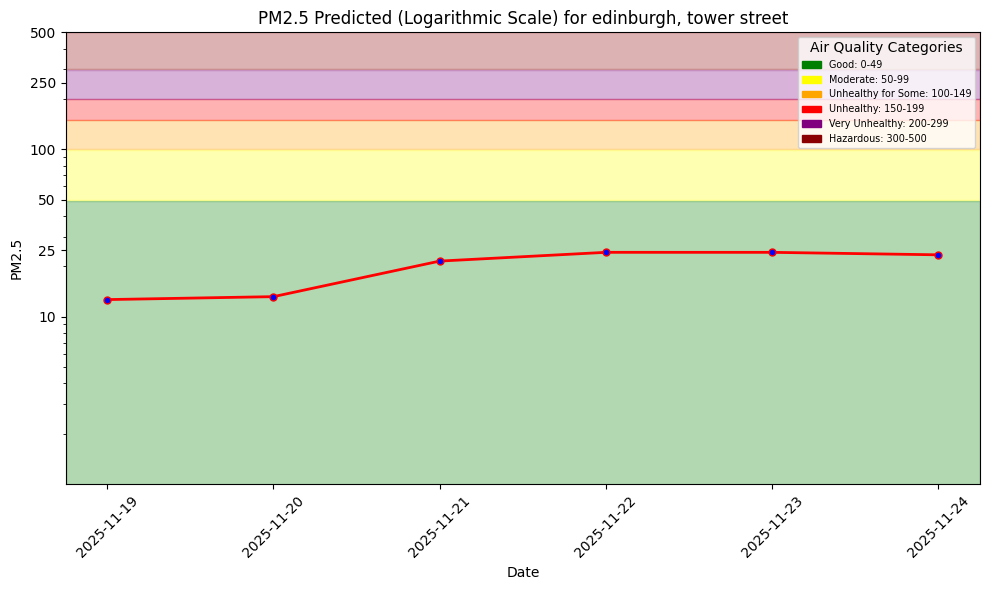

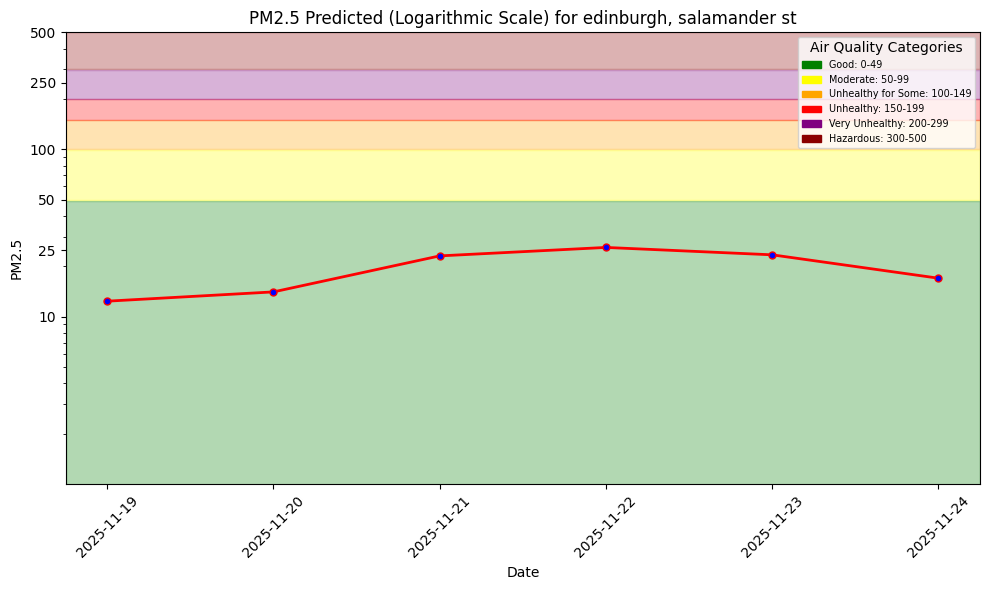

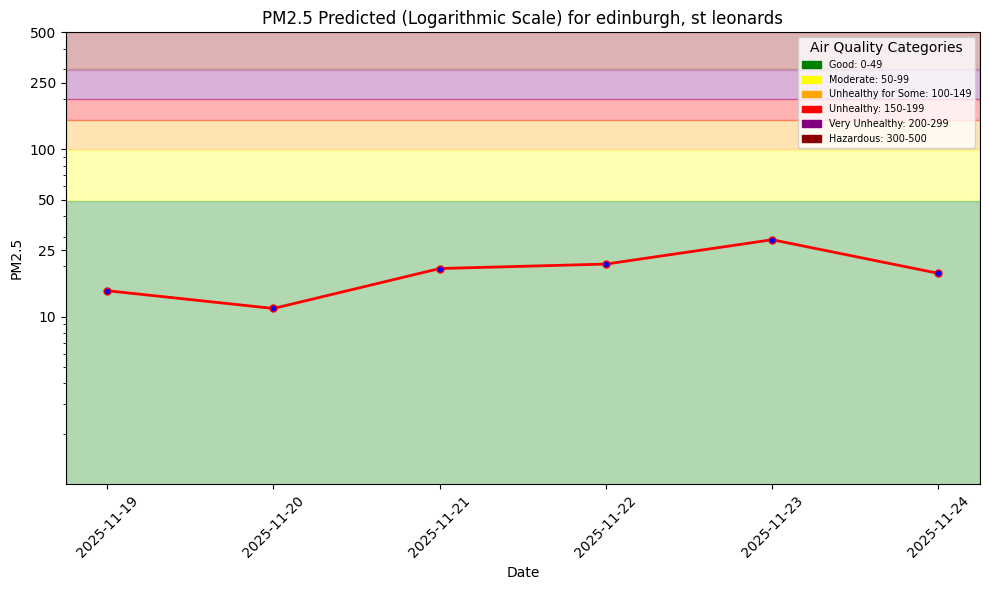

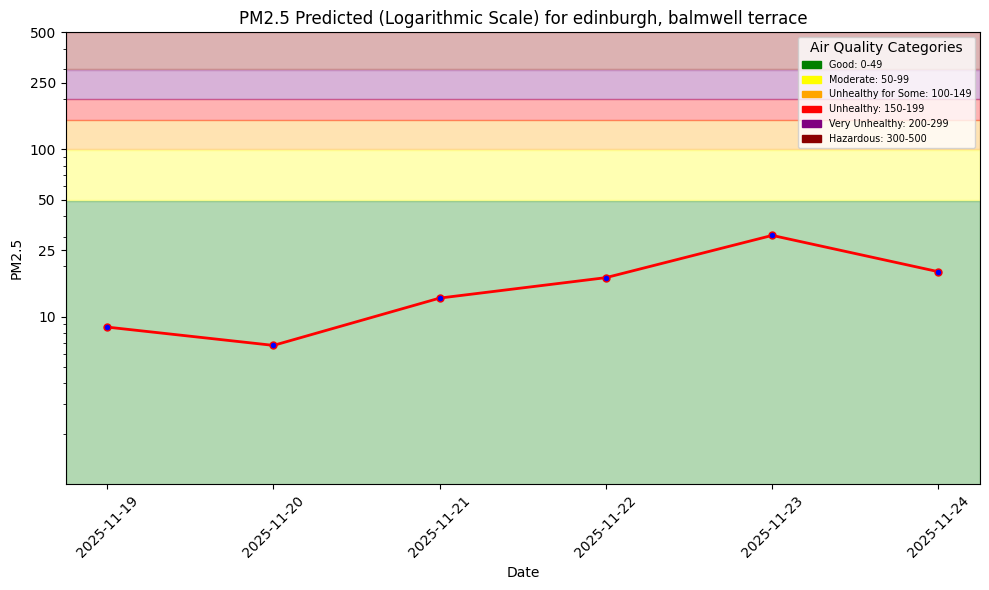

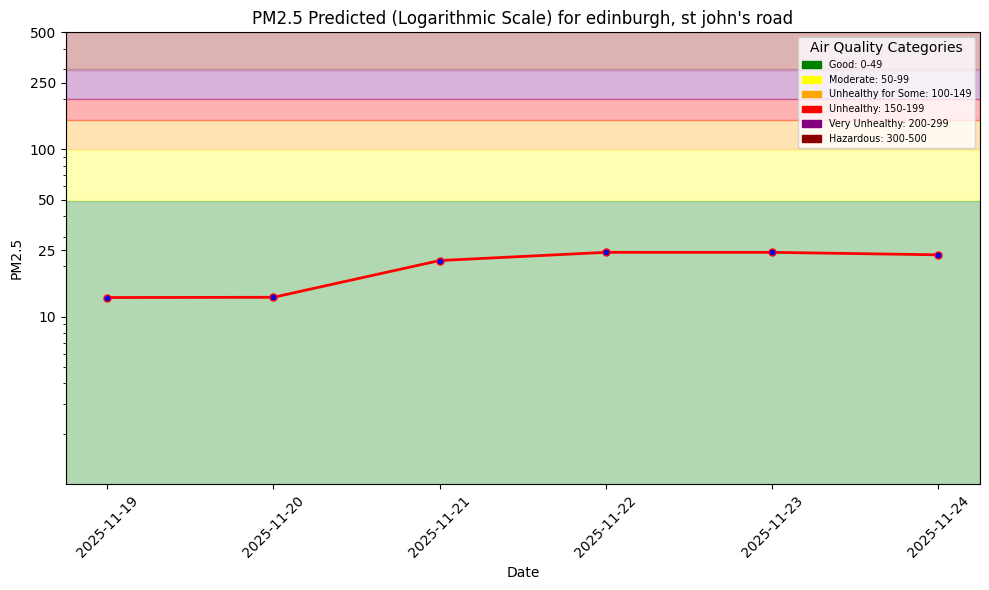

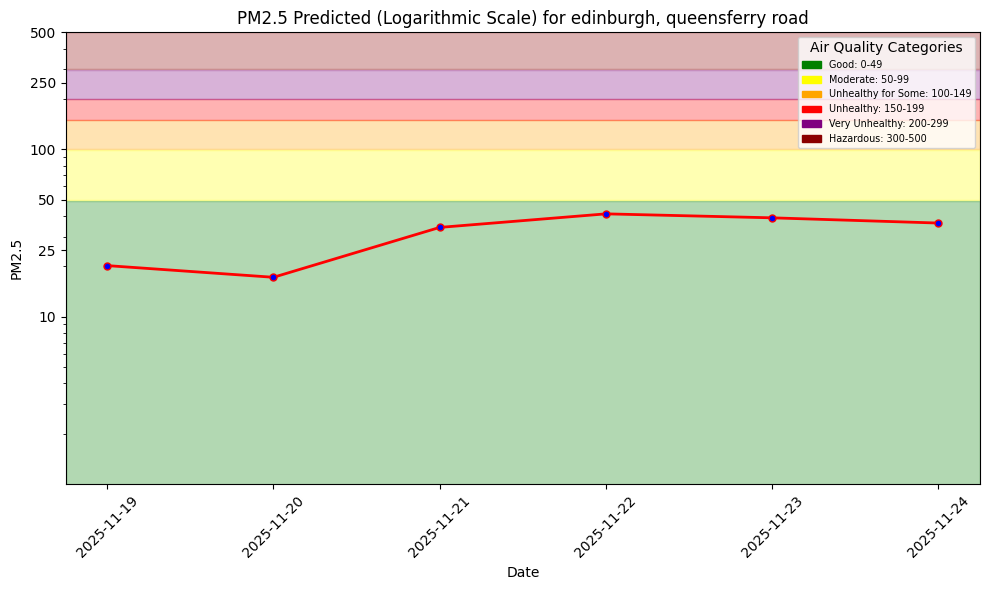

In [12]:
if running_e or running_c:
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
    plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

    plt.show()

if running_a:
    for batch_df in batch_data_frames:
        street = batch_df['street'][0]
        pred_file_path = f"{root_dir}/docs/air-quality_a/assets/img/pm25_forecast{street}.png"
        plt = util.plot_air_quality_forecast(city, street, batch_df, pred_file_path)

        plt.show()

In [13]:
# Get or create feature group

#Select version of feature group
if running_e:
    m_version = 1

if running_c:
    m_version = 2

if running_a:
    m_version = 3

monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=m_version,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [14]:
if running_e or running_c:
    monitor_fg.insert(batch_data, wait=True)

if running_a:
    all_data_frames = None
    for frame in batch_data_frames:
        if all_data_frames == None:
            all_data_frames = frame
        else:
            all_data_frames.append(frame)
    monitor_fg.insert(all_data_frames, wait=True)

                       date  weather_temperature_2m_mean  \
0 2025-11-19 00:00:00+00:00                         2.40   
1 2025-11-20 00:00:00+00:00                         3.45   
2 2025-11-21 00:00:00+00:00                         2.80   
3 2025-11-22 00:00:00+00:00                         7.20   
4 2025-11-23 00:00:00+00:00                         3.45   
5 2025-11-24 00:00:00+00:00                         5.95   

   weather_precipitation_sum  weather_wind_speed_10m_max  \
0                        0.0                   15.683774   
1                        0.0                   16.489416   
2                        0.0                   12.031756   
3                        0.0                   17.727943   
4                        0.1                    4.510787   
5                        0.1                   24.031178   

   weather_wind_direction_10m_dominant       city  lagged_aq_1_day  \
0                           301.865936  edinburgh        10.000000   
1                 

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272015/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 13:37:32,057 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 13:37:35,256 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 13:39:14,988 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 13:39:15,164 INFO: Waiting for log aggregation to finish.
2025-11-18 13:39:44,176 INFO: Execution finished successfully.
                       date  weather_temperature_2m_mean  \
0 2025-11-19 00:00:00+00:00                         2.40   
1 2025-11-20 00:00:00+00:00                         3.45   
2 2025-11-21 00:00:00+00:00                         2.80   
3 2025-11-22 00:00:00+00:00                         7.20 

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272015/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 13:39:59,770 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 13:40:06,200 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 13:42:15,013 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-18 13:42:18,232 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 13:42:18,398 INFO: Waiting for log aggregation to finish.
2025-11-18 13:42:30,438 INFO: Execution finished successfully.
                       date  weather_temperature_2m_mean  \
0 2025-11-19 00:00:00+00:00                         2.40   
1 2025-11-20 00:00:00+00:00                         3.45   
2 2025

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272015/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 13:42:47,537 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 13:42:50,794 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 13:44:43,740 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 13:44:43,918 INFO: Waiting for log aggregation to finish.
2025-11-18 13:45:13,182 INFO: Execution finished successfully.
                       date  weather_temperature_2m_mean  \
0 2025-11-19 00:00:00+00:00                         2.40   
1 2025-11-20 00:00:00+00:00                         3.45   
2 2025-11-21 00:00:00+00:00                         2.80   
3 2025-11-22 00:00:00+00:00                         7.20 

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272015/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 13:45:29,843 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 13:45:36,340 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 13:47:55,428 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 13:47:55,607 INFO: Waiting for log aggregation to finish.
2025-11-18 13:48:45,073 INFO: Execution finished successfully.
                       date  weather_temperature_2m_mean  \
0 2025-11-19 00:00:00+00:00                         2.40   
1 2025-11-20 00:00:00+00:00                         3.45   
2 2025-11-21 00:00:00+00:00                         2.80   
3 2025-11-22 00:00:00+00:00                         7.20   


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272015/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 13:49:01,654 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 13:49:04,868 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 13:50:48,281 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-18 13:50:54,716 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 13:50:55,138 INFO: Waiting for log aggregation to finish.
2025-11-18 13:50:55,139 INFO: Execution finished successfully.
                       date  weather_temperature_2m_mean  \
0 2025-11-19 00:00:00+00:00                         2.40   
1 2025-11-20 00:00:00+00:00                         3.45   
2 2

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272015/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-18 13:51:11,669 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 13:51:14,886 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 13:52:42,235 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-18 13:52:45,477 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 13:52:45,643 INFO: Waiting for log aggregation to finish.
2025-11-18 13:52:54,430 INFO: Execution finished successfully.


In [15]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.13s) 


,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,city,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,22.0,21.0,26.0,12.548160,tower street,united-kingdom,1
1,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,21.0,20.0,22.0,13.095717,salamander st,united-kingdom,1
2,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,19.0,19.0,21.0,19.842331,st leonards,united-kingdom,1
3,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,4.0,6.0,7.0,26.200932,balmwell terrace,united-kingdom,1
4,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,18.0,20.0,22.0,18.295746,st john's road,united-kingdom,1
5,2025-11-18 00:00:00+00:00,0.95,0.3,4.104631,15.255177,edinburgh,18.0,17.0,20.0,22.494715,queensferry road,united-kingdom,1
6,2025-11-19 00:00:00+00:00,2.40,0.0,15.683774,301.865936,edinburgh,10.0,22.0,21.0,12.654166,tower street,united-kingdom,1
7,2025-11-19 00:00:00+00:00,2.40,0.0,15.683774,301.865936,edinburgh,11.0,21.0,20.0,12.380716,salamander st,united-kingdom,1
8,2025-11-19 00:00:00+00:00,2.40,0.0,15.683774,301.865936,edinburgh,8.0,19.0,19.0,14.299752,st leonards,united-kingdom,1
9,2025-11-19 00:00:00+00:00,2.40,0.0,15.683774,301.865936,edinburgh,3.0,4.0,6.0,8.667590,balmwell terrace,united-kingdom,1


In [ ]:
#Select version of feature group
if running_e:
    aq_version = 1

if running_c:
    aq_version = 2

if running_a:
    aq_version = 3
    
air_quality_fg = fs.get_feature_group(name='air_quality', version=aq_version)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.97s) 


,date,pm25,country,city,street,url,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days
0,2024-01-14 00:00:00+00:00,9.00,united-kingdom,edinburgh,tower street,https://api.waqi.info/feed/@11656/,12.0,16.00,9.00
1,2024-04-02 00:00:00+00:00,10.00,united-kingdom,edinburgh,st leonards,https://api.waqi.info/feed/@5987/,22.0,24.00,12.00
2,2023-04-09 00:00:00+00:00,47.00,united-kingdom,edinburgh,queensferry road,https://api.waqi.info/feed/@5985/,40.0,21.00,13.00
3,2022-12-20 00:00:00+00:00,24.00,united-kingdom,edinburgh,st leonards,https://api.waqi.info/feed/@5987/,9.0,31.00,17.00
4,2021-09-01 00:00:00+00:00,3.97,united-kingdom,edinburgh,balmwell terrace,https://api.waqi.info/feed/A93199/,2.5,2.04,1.08
...,...,...,...,...,...,...,...,...,...
17082,2025-11-18 00:00:00+00:00,28.00,united-kingdom,edinburgh,queensferry road,https://api.waqi.info/feed/@5985/,18.0,17.00,20.00
17083,2025-11-18 00:00:00+00:00,11.00,united-kingdom,edinburgh,salamander st,https://api.waqi.info/feed/@5986/,21.0,20.00,22.00
17084,2025-11-18 00:00:00+00:00,8.00,united-kingdom,edinburgh,st leonards,https://api.waqi.info/feed/@5987/,19.0,19.00,21.00
17085,2025-11-18 00:00:00+00:00,9.00,united-kingdom,edinburgh,st john's road,https://api.waqi.info/feed/@9580/,18.0,20.00,22.00


In [ ]:
def backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, model):
    features_df = weather_fg.read()
    all_features_df = pd.merge(air_quality_df[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days', 'date']], features_df[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'date', 'city']])
    all_features_df = all_features_df.sort_values(by=['date'], ascending=True)
    all_features_df = all_features_df.tail(10)

    if running_c:
    
        all_features_df['predicted_pm25'] = model.predict(all_features_df[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','weather_temperature_2m_mean', 'weather_precipitation_sum', 'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant']])
        df = pd.merge(all_features_df, air_quality_df[['date','pm25','street','country']], on="date")
        df['days_before_forecast_day'] = 1
        hindcast_df = df
        df = df.drop('pm25', axis=1)
       
        monitor_fg.insert(df, write_options={"wait_for_job": True})

    if running_a:
        street = air_quality_df.iloc[0]['street']
        all_features_df.rename(columns={'temperature_2m_mean' : 'weather_temperature_2m_mean', 'precipitation_sum' : 'weather_precipitation_sum','wind_speed_10m_max' : 'weather_wind_speed_10m_max', 'wind_direction_10m_dominant' : 'weather_wind_direction_10m_dominant'}, inplace=True)

        all_features_df['predicted_pm25'] = model[street].predict(
            all_features_df[['lagged_aq_1_day','lagged_aq_2_days', 'lagged_aq_3_days','weather_temperature_2m_mean', 'weather_precipitation_sum', 'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant']])

        df = pd.merge(all_features_df, air_quality_df[['date','pm25','street','country']], on="date")
        df['days_before_forecast_day'] = 1
        hindcast_df = df
        df = df.drop('pm25', axis=1)
       
        monitor_fg.insert(df, write_options={"wait_for_job": True})

    return hindcast_df
    



In [ ]:


if running_e or running_c:
    outcome_df = air_quality_df[['date', 'pm25']]
    preds_df =  monitoring_df[['date', 'predicted_pm25']]

    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])

    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        hindcast_df = backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
    hindcast_df

if running_a:
    outcome_df = air_quality_df[['date', 'pm25', 'street']]
    preds_df =  monitoring_df[['date', 'predicted_pm25', 'street']]

    hindcast_df = pd.merge(preds_df, outcome_df, on=['date', 'street'])    
    
    hindcast_dfs = []
    for location in locations:
        sensor_hindcast_df = hindcast_df[hindcast_df['street'] == location['street']]
        sensor_aq_df = air_quality_df[air_quality_df['street'] == location['street']]
        
        sensor_hindcast_df = sensor_hindcast_df.sort_values(by=['date'])

        # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
        if len(sensor_hindcast_df) == 0:
            sensor_hindcast_df = backfill_predictions_for_monitoring(weather_fg, sensor_aq_df, monitor_fg, models)
        
        hindcast_dfs.append(sensor_hindcast_df)

hindcast_dfs[1]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.47s) 
   lagged_aq_1_day  lagged_aq_2_days  lagged_aq_3_days  \
0             43.0              38.0              46.0   
1             27.0              43.0              38.0   
2             20.0              27.0              43.0   
3              9.0              20.0              27.0   
4             14.0               9.0              20.0   
5             25.0              14.0               9.0   
6             20.0              25.0              14.0   
7             26.0              20.0              25.0   
8             21.0              26.0              20.0   
9             22.0              21.0              26.0   

                       date  weather_temperature_2m_mean  \
0 2025-11-09 00:00:00+00:00                    10.815417   
1 2025-11-10 00:00:00+00:00                    10.140416   
2 2025-11-11 00:00:00+00:00                     9.417500   
3 2025-11-12 00:00:00+00:00        

,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days,date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,44.0,40.0,48.0,2025-11-09 00:00:00+00:00,10.815417,6.600000,21.928255,179.526779,edinburgh,24.162981,28.0,salamander st,united-kingdom,1
1,28.0,44.0,40.0,2025-11-10 00:00:00+00:00,10.140416,7.300000,18.623693,193.695908,edinburgh,15.918004,22.0,salamander st,united-kingdom,1
2,22.0,28.0,44.0,2025-11-11 00:00:00+00:00,9.417500,12.700001,27.865139,184.715332,edinburgh,14.631166,10.0,salamander st,united-kingdom,1
3,10.0,22.0,28.0,2025-11-12 00:00:00+00:00,10.794583,1.000000,28.901070,222.097748,edinburgh,13.631772,13.0,salamander st,united-kingdom,1
4,13.0,10.0,22.0,2025-11-13 00:00:00+00:00,7.040417,37.700001,36.792282,50.389328,edinburgh,17.509743,26.0,salamander st,united-kingdom,1
5,26.0,13.0,10.0,2025-11-14 00:00:00+00:00,6.671666,0.400000,34.438377,56.821453,edinburgh,30.798210,19.0,salamander st,united-kingdom,1
6,19.0,26.0,13.0,2025-11-15 00:00:00+00:00,9.050000,0.000000,19.416653,79.315140,edinburgh,20.265511,22.0,salamander st,united-kingdom,1
7,22.0,19.0,26.0,2025-11-16 00:00:00+00:00,6.150000,0.000000,11.183201,303.178528,edinburgh,28.198187,20.0,salamander st,united-kingdom,1
8,20.0,22.0,19.0,2025-11-17 00:00:00+00:00,4.600000,0.000000,12.594856,300.963684,edinburgh,20.455107,21.0,salamander st,united-kingdom,1
9,21.0,20.0,22.0,2025-11-18 00:00:00+00:00,2.500000,0.700000,11.019764,38.367523,edinburgh,23.542799,11.0,salamander st,united-kingdom,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

0    tower street
Name: street, dtype: object


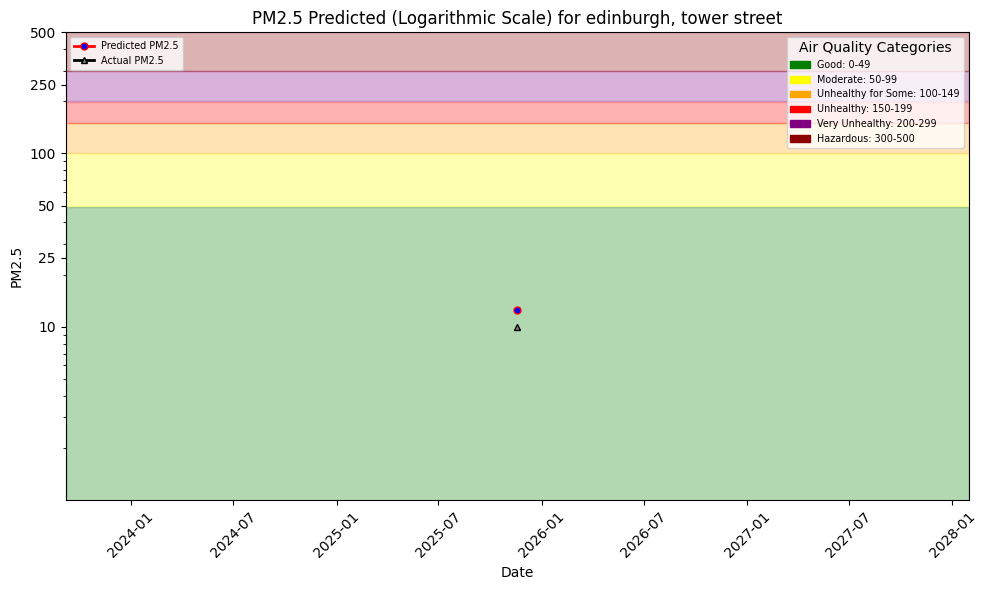

1    salamander st
Name: street, dtype: object


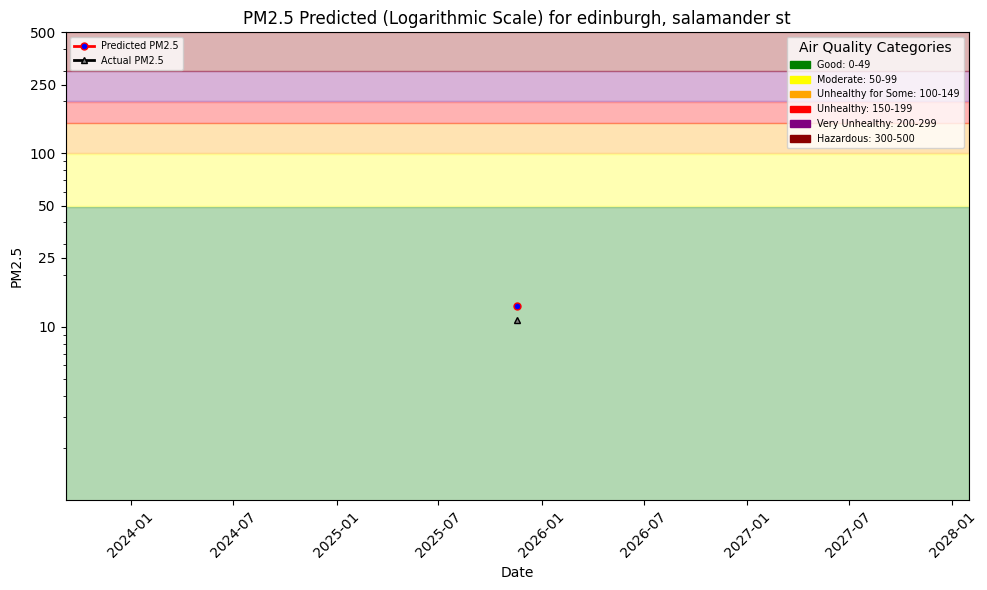

2    st leonards
Name: street, dtype: object


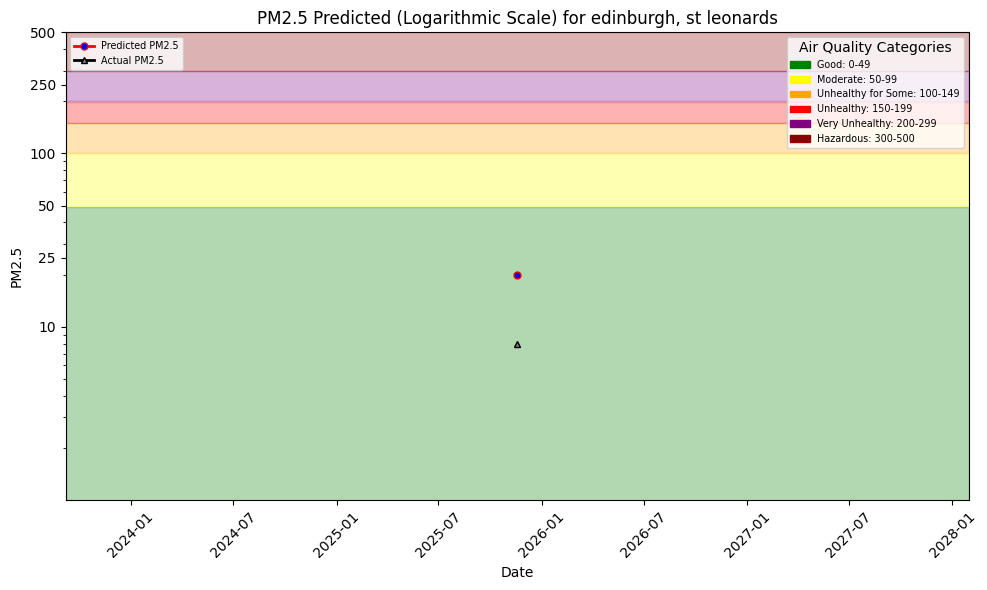

3    balmwell terrace
Name: street, dtype: object


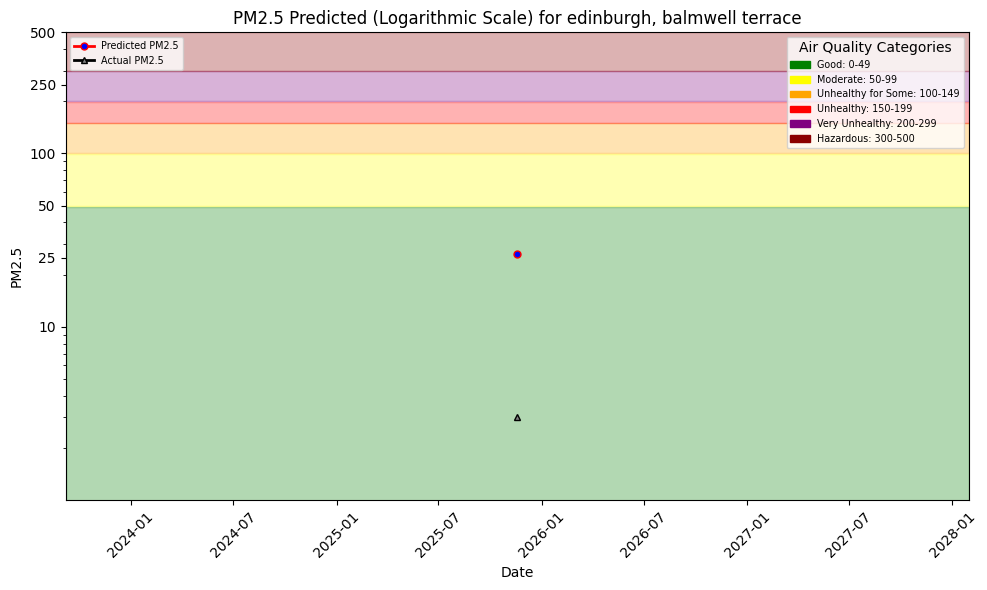

4    st john's road
Name: street, dtype: object


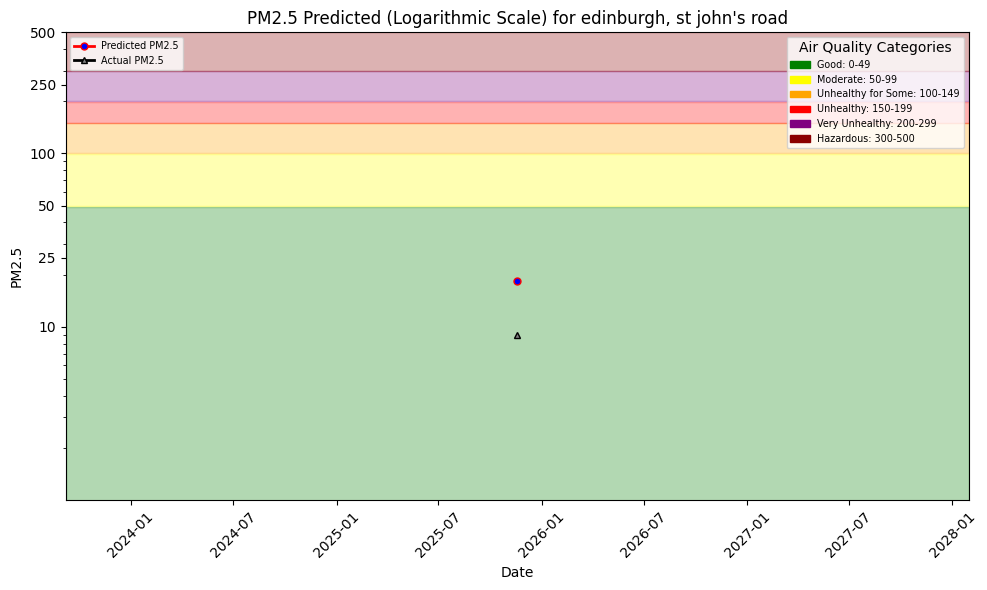

5    queensferry road
Name: street, dtype: object


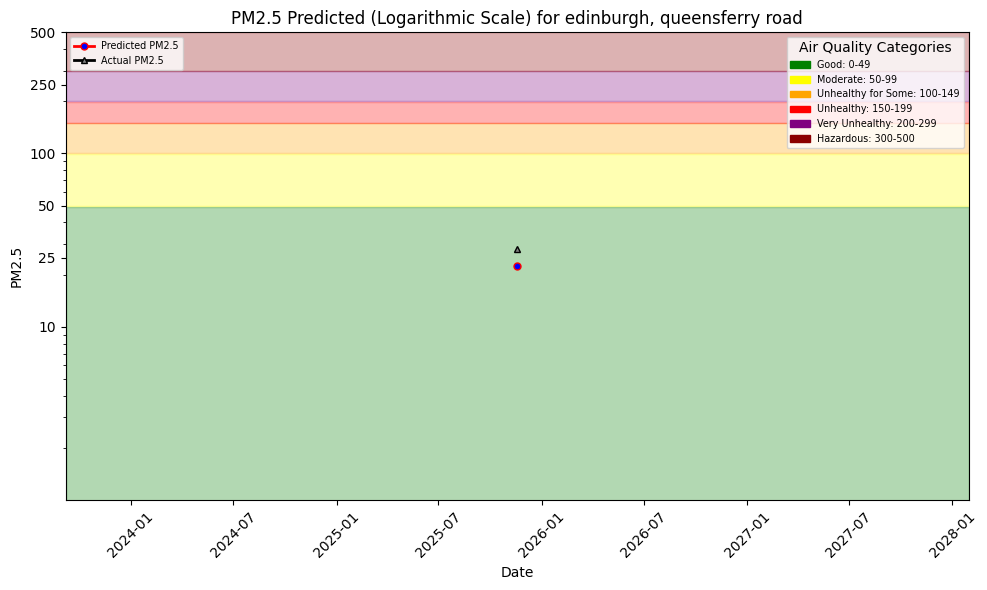

In [ ]:
if running_e or running_c:
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()

if running_a:
    for h_df in hindcast_dfs:
        street = h_df.iloc[0]['street']
        hindcast_file_path = f"{root_dir}/docs/air-quality_a/assets/img/pm25_hindcast_1day{street}.png"
        plt = util.plot_air_quality_forecast(city, street, h_df, hindcast_file_path, hindcast=True)
        plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [47]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")

if running_e or running_c:
    dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

if running_a:
    for location in locations:
        street = location['street']
        dataset_api.upload(f"{root_dir}/docs/air-quality_a/assets/img/pm25_forecast{street}.png", f"Resources/airquality_a/{city}_{street}_{str_today}", overwrite=True)
        dataset_api.upload(f"{root_dir}/docs/air-quality_a/assets/img/pm25_hindcast_1day{street}.png", f"Resources/airquality_a/{city}_{street}_{str_today}", overwrite=True)


proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality_a/ass…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality_a/ass…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality_a/ass…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality_a/ass…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality_a/ass…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality_a/ass…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality_a/ass…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality_a/ass…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality_a/ass…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality_a/ass…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality_a/ass…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/docs/air-quality_a/ass…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272015/settings/fb/path/Resources/airquality


---